# Deep Learning for the Geosciences (Technion 16837)

## Assignment #3c: Wildfires

In [2]:
import numpy as np # Importing the numpy package to perform calculations
import matplotlib.pyplot as plt # Importing the pyplot package to plot data
import sys
import os
from PIL import Image

%matplotlib inline

# Import local files
sys.path.append('code')
from utils import *
from nn import *

# Do not change below! Important for reloading code you write in external .py files.
%load_ext autoreload 
%autoreload 2 

---
## <ins>Note about chatGPT </ins>
As always, you may use chatGPT to complete your assignments, if you indicate you did. However, since our goal here is not only to get a good grade - but also to learn something - I recommend that you first attempt to solve the assignment yourself and only then look at what ChatGPT has to offer. 

When choosing to use ChatGPT:
1. Please write your input prompt.
2. Try to understand the code instead of just copying it.
3. Explain the code in words. What does each line do? What is the expected input and output?

Important note: Failing to disclose the use of ChatGPT or similar AI tools in an assignment may lead to the loss of all points for the assignment.

---

# 0. <ins>Preface</ins>
Seeing the dangers of wildfires across the globe, you decide to design a deep learning algorithm that will detect bushfires and wildfires in arid climates. You have already secured funding for a drone which will patrol the skies of the northern Negev desert, and now require to train a model whose weights will be used to detect wildfires in real time.

In this notebook, you will train a neural network to distinguish between fires and non-fires.

# 1. <ins>Load the wildfires data</ins>
The wildfire imagery data you will use was artifically constructed by Davis et al., 2023 (https://www.mdpi.com/2571-6255/6/11/418).

To construct a training dataset, Davis et al. started a controlled bushfire in the Utah desert. They took pictures of this controlled fire from various camera angles. To construct a negative dataset ("no fire"), they took pictures of the desert surrounding their controlled fire.

Use the cell below to load the images. Create a vector of labels (0: no fire, 1:fire) to correspond to each image. Divide the dataset into training (80%) and testing (20%).

## 1a. Load images

In [4]:
# Load images from both directories
fire_images = load_images_and_labels('./data/fire', 1)
nofire_images = load_images_and_labels('./data/nofire', 0)

# Combine the datasets
all_images = fire_images + nofire_images

# Shuffle the combined dataset to ensure random distribution
np.random.shuffle(all_images)

# Separate the images and labels
images, labels = zip(*all_images)
images = np.array(images)
labels = np.array(labels)

# Manual train-test split
split_ratio = 0.8  # 80% for training, 20% for testing
split_index = int(len(images) * split_ratio)

train_images, test_images = images[:split_index], images[split_index:]
train_labels, test_labels = labels[:split_index], labels[split_index:]

## 1b. Show five random images of "fire"

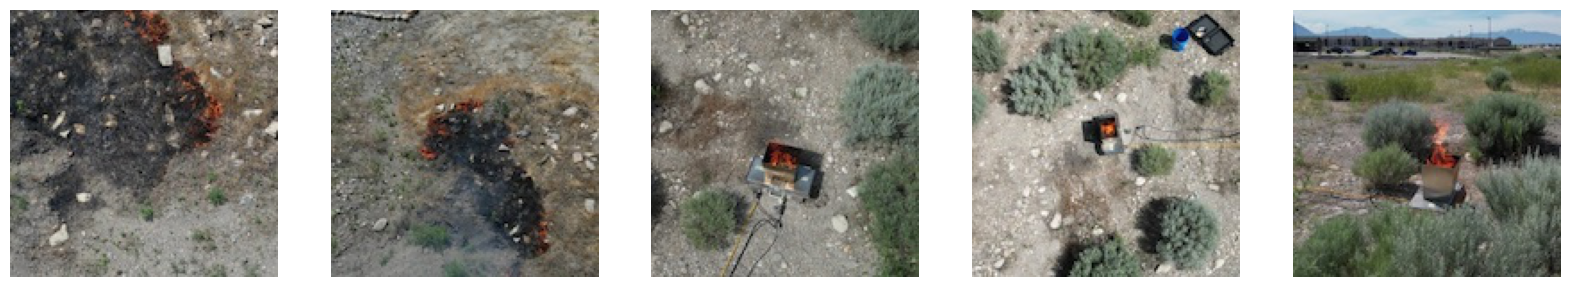

In [5]:
# Find indices of "fire" images, where label == 1
fire_indices = np.where(train_labels == 1)[0]

# Randomly select 5 indices from the fire_indices list
selected_indices = np.random.choice(fire_indices, size=5, replace=False)

# Display the selected "fire" images
fig, axes = plt.subplots(1, 5, figsize=(20, 4)) # Adjust figsize as needed
for ax, idx in zip(axes, selected_indices):
    ax.imshow(train_images[idx])
    ax.axis('off')
plt.show()

## 1c. Flatten image to create train and test sets

In [6]:
n_samples = train_images.shape[0]
height = train_images.shape[1]
width = train_images.shape[2]
channels = train_images.shape[3]

X_flattened = train_images.reshape(n_samples, height * width * channels)  
y_true = train_labels.reshape(-1, 1)

n_samples_test = test_images.shape[0]
X_test_flattened = test_images.reshape(n_samples_test, -1)
y_true_test = test_labels.reshape(-1, 1)

# 2. <ins>Train your neural network</ins>
Train the 3-layer neural network you developed in the circles.ipynb notebook on the fire and nofire images.

## 2a. Initialize the weights and bises

In [11]:
n_features = height * width * channels  # Assuming images have been flattened
n_hidden1 = 100  # Size of the first hidden layer
n_hidden2 = 100  # Size of the second hidden layer
n_hidden3 = 100  # Size of the third hidden layer
n_output = 1  # Since we're doing binary classification

# Initialize weights with small random values and biases with zeros
W1 = np.random.randn(n_features, n_hidden1) * 0.01
b1 = np.zeros(n_hidden1)
W2 = np.random.randn(n_hidden1, n_hidden2) * 0.01
b2 = np.zeros(n_hidden2)
W3 = np.random.randn(n_hidden2, n_hidden3) * 0.01
b3 = np.zeros(n_hidden3)
W4 = np.random.randn(n_hidden3, n_output) * 0.01
b4 = np.zeros(n_output)

# Train the network: call the train_network function as before. This time return the losses, to plot them later.
### YOUR CODE HERE

W1, b1, W2, b2, W3, b3, W4, b4, trainloss, testloss = train_network(X_flattened, y_true, W1, b1, W2, b2, W3, b3, W4, b4,
                                               learning_rate=0.01, iterations=1000, X_test = X_test_flattened, y_test = y_true_test)


### YOUR CODE HERE

Iteration 0: Train Loss = 0.2498
Iteration 0: Test Loss = 0.2529
Iteration 10: Train Loss = 0.2459
Iteration 10: Test Loss = 0.2469


KeyboardInterrupt: 

# 3. <ins>Test your model</ins>
1. What are the hyperparameters of this neural network?
2. Plot the loss function. Try changing the hyperparameters. Which set of hyperparameters yields the lowest loss?
3. Compute the accuracy using the code in the cell below.

In [13]:
# Make predictions
_, _, _, predictions = forward_pass(X_test_flattened, W1, b1, W2, b2, W3, b3, W4, b4)

# Convert probabilities to binary labels based on a 0.5 threshold
predicted_labels = (predictions > 0.5).astype(int)

# Calculate accuracy
accuracy = np.mean(predicted_labels == y_true_test)

print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.8081


***
## <font color='lightgreen'>Answer the following questions</font>
1. Plot the train and test loss functions for a few sets of hyperparameters. Describe how each hyperparameter affects the loss functions.
2. What happens when you set the initial bias to be much greater than the weights?
3. Qualitatively describe the training: does it "wiggle"? Is the slope decreasing steadily?
4. Does your model overfit? How do you know?

In [37]:
from tqdm import tqdm
datalogger =[]
for n in tqdm([150,200,500]):
    for lr in tqdm([0.001,0.01,0.1]):
        for w in tqdm([0.01,0.05]):
            for b in tqdm([0.5,1]):
                n_features = height * width * channels  # Assuming images have been flattened
                n_hidden1 = n  # Size of the first hidden layer
                n_hidden2 = n  # Size of the second hidden layer
                n_hidden3 = n  # Size of the third hidden layer
                n_output = 1  # Since we're doing binary classification
                
                # Initialize weights with small random values and biases with zeros
                W1 = np.random.randn(n_features, n_hidden1) * w
                b1 = np.ones(n_hidden1) * b
                W2 = np.random.randn(n_hidden1, n_hidden2) * w
                b2 = np.ones(n_hidden2) * b
                W3 = np.random.randn(n_hidden2, n_hidden3) * w
                b3 = np.ones(n_hidden3) * b
                W4 = np.random.randn(n_hidden3, n_output) * w
                b4 = np.ones(n_output) * b
                
                # Train the network: call the train_network function as before. This time return the losses, to plot them later.
                ### YOUR CODE HERE
                
                W1, b1, W2, b2, W3, b3, W4, b4, trainloss, testloss = train_network(X_flattened, y_true, W1, b1, W2, b2, W3, b3, W4, b4,
                                                               learning_rate =lr, iterations=500, X_test = X_test_flattened, y_test = y_true_test)
                
                # Make predictions
                _, _, _, predictions = forward_pass(X_test_flattened, W1, b1, W2, b2, W3, b3, W4, b4)
                
                # Convert probabilities to binary labels based on a 0.5 threshold
                predicted_labels = (predictions > 0.5).astype(int)
                
                # Calculate accuracy
                accuracy = np.mean(predicted_labels == y_true_test)
                ### YOUR CODE HERE

                datalogger.append([trainloss[-1], testloss[-1],n, lr,w,b,accuracy])

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/2 [00:00<?, ?it/s]


  0%|          | 0/2 [00:00<?, ?it/s]


 50%|█████     | 1/2 [11:20<11:20, 680.86s/it]


100%|██████████| 2/2 [21:38<00:00, 649.38s/it]


 50%|█████     | 1/2 [21:38<21:38, 1298.77s/it]


  0%|          | 0/2 [00:00<?, ?it/s]


 50%|█████     | 1/2 [10:14<10:14, 614.55s/it]


100%|██████████| 2/2 [20:25<00:00, 612.59s/it]


100%|██████████| 2/2 [42:03<00:00, 1261.98s/it]

 33%|███▎      | 1/3 [42:03<1:24:07, 2523.97s/it]

  0%|          | 0/2 [00:00<?, ?it/s]


  0%|          | 0/2 [00:00<?, ?it/s]


 50%|█████     | 1/2 [3:53:27<3:53:27, 14007.95s/it]


100%|██████████| 2/2 [4:04:09<00:00, 7324.93s/it]   


 50%|█████     | 1/2 [4:04:09<4:04:09, 14649.87s/it]


  0%|          | 0/2 [00:00<?, ?it/s]


 50%|█████     | 1/2 [10:47<10:47, 647.28s/it]


100%|██████████| 2/2 [21:33<00:00, 646.94s/it]


100%|██████████| 2/2 [4:25:43<00:00, 7971.88s/it]   

 67%|██████▋   | 2/3 [5:07:47<2:53:37, 10417.97s/it]

  0%

In [38]:
datalogger = np.row_stack(datalogger)

In [39]:
datalogger = np.column_stack((np.array(list(range(1,len(datalogger)+1))).reshape(-1,1),datalogger))

In [40]:
np.savetxt("logger2.csv",datalogger, delimiter = ",")

In [15]:
n = 500
lr = 0.001
w = 0.01
b = 0.5


n_features = height * width * channels  # Assuming images have been flattened
n_hidden1 = n  # Size of the first hidden layer
n_hidden2 = n  # Size of the second hidden layer
n_hidden3 = n  # Size of the third hidden layer
n_output = 1  # Since we're doing binary classification

# Initialize weights with small random values and biases with zeros
W1 = np.random.randn(n_features, n_hidden1) * w
b1 = np.ones(n_hidden1) * b
W2 = np.random.randn(n_hidden1, n_hidden2) * w
b2 = np.ones(n_hidden2) * b
W3 = np.random.randn(n_hidden2, n_hidden3) * w
b3 = np.ones(n_hidden3) * b
W4 = np.random.randn(n_hidden3, n_output) * w
b4 = np.ones(n_output) * b

# Train the network: call the train_network function as before. This time return the losses, to plot them later.
### YOUR CODE HERE

W1, b1, W2, b2, W3, b3, W4, b4, trainloss, testloss = train_network(X_flattened, y_true, W1, b1, W2, b2, W3, b3, W4, b4,
                                               learning_rate =lr, iterations=5000, X_test = X_test_flattened, y_test = y_true_test)

# Make predictions
_, _, _, predictions = forward_pass(X_test_flattened, W1, b1, W2, b2, W3, b3, W4, b4)

# Convert probabilities to binary labels based on a 0.5 threshold
predicted_labels = (predictions > 0.5).astype(int)

# Calculate accuracy
accuracy = np.mean(predicted_labels == y_true_test)
### YOUR CODE HERE

# Make predictions
_, _, _, predictions = forward_pass(X_test_flattened, W1, b1, W2, b2, W3, b3, W4, b4)

# Convert probabilities to binary labels based on a 0.5 threshold
predicted_labels = (predictions > 0.5).astype(int)

# Calculate accuracy
accuracy = np.mean(predicted_labels == y_true_test)

print(f"Accuracy: {accuracy:.4f}")

Iteration 0: Train Loss = 0.3721
Iteration 0: Test Loss = 0.3317
Iteration 100: Train Loss = 0.2131
Iteration 100: Test Loss = 0.2411
Iteration 200: Train Loss = 0.1860
Iteration 200: Test Loss = 0.2238
Iteration 300: Train Loss = 0.1636
Iteration 300: Test Loss = 0.2111
Iteration 400: Train Loss = 0.1421
Iteration 400: Test Loss = 0.1989
Iteration 500: Train Loss = 0.1204
Iteration 500: Test Loss = 0.1857
Iteration 600: Train Loss = 0.0992
Iteration 600: Test Loss = 0.1725
Iteration 700: Train Loss = 0.0831
Iteration 700: Test Loss = 0.1638
Iteration 800: Train Loss = 0.0784
Iteration 800: Test Loss = 0.1657
Iteration 900: Train Loss = 0.0313
Iteration 900: Test Loss = 0.1133
Iteration 1000: Train Loss = 0.0200
Iteration 1000: Test Loss = 0.1035
Iteration 1100: Train Loss = 0.0138
Iteration 1100: Test Loss = 0.0999
Iteration 1200: Train Loss = 0.0101
Iteration 1200: Test Loss = 0.0969
Iteration 1300: Train Loss = 0.0074
Iteration 1300: Test Loss = 0.0950
Iteration 1400: Train Loss = 0

In [25]:
_, _, _, predictions = forward_pass(X_test_flattened, W1, b1, W2, b2, W3, b3, W4, b4)

# Convert probabilities to binary labels based on a 0.5 threshold
predicted_labels = (predictions > 0.5).astype(int)

# Calculate accuracy
accuracy = np.mean(predicted_labels == y_true_test)

print(f"Accuracy: {accuracy:.4f}")

Accuracy: 0.8939


In [24]:
np.save("b4",b4)

In [28]:
np.savetxt("testloss.csv",testloss, delimiter = ",")